In [11]:
import requests
from lxml import html 
import pandas as pd
import re
import MySQLdb as mdb
import sys
import datetime
import time
from sqlalchemy import create_engine
from wordcloud import WordCloud
from nltk.corpus import stopwords
from wordcloud import STOPWORDS
import matplotlib.pyplot as plt

url = "http://www.economist.com/sections/leaders"
response = requests.get(url) # get the html of that url
doc = html.fromstring(response.text) # parse it and create a document

In [2]:
articleNodes = doc.xpath("//article[@class='teaser']")
regex = re.compile(r'\w{3}\W*\w+\W*\d{4}')

In [3]:
def parseArticleNode(article):
    topic = article.xpath(".//a/div/h2/span[@class='flytitle-and-title__flytitle']")[0].text_content()
    headline = article.xpath(".//a/div/h2/span[@class='flytitle-and-title__title']")[0].text_content()
    headline_link = str("economist.com"+article.xpath(".//a")[0].get("href"))
    description = article.xpath(".//a/div/div[@class = 'teaser__text']")[0].text_content()
    day = article.xpath(".//a/div/div/time")[0].text_content()
    matches = regex.finditer(day)
    for match in matches:
        day = match.group()
    
    result = {
        "Title": headline,
        "Topic": topic,
        "URL" : headline_link,
        "Description" : description,
        "Date" : day
    }
    return result

data = [parseArticleNode(article) for article in articleNodes]


In [4]:
#SETTING UP THE DATABASE CONNECTION
con = mdb.connect(host = 'localhost', 
                  user = 'root', 
                  passwd = 'dwdstudent2015', 
                  charset='utf8', use_unicode=True);

# Check for existing database
##db_name = 'NYTimes'
#drop_db_query = "DROP DATABASE IF EXISTS {db}".format(db=db_name)
#cursor = con.cursor()
#cursor.execute(drop_db_query)
#cursor.close()

# Create the database
def createDB():
    db_name = 'Economist'
    create_db_query = "CREATE DATABASE IF NOT EXISTS {db} DEFAULT CHARACTER SET 'utf8'".format(db=db_name)

    cursor = con.cursor()
    cursor.execute(create_db_query)
    cursor.close()
    return

In [5]:
#Create time invariant table
def createInvariant():
    cursor = con.cursor()
    db_name = 'Economist'
    table1_name = 'Articles_Constant'
    # The {db} and {table} are placeholders for the parameters in the format(....) statement
    create_table_query = '''CREATE TABLE IF NOT EXISTS {db}.{table} 
                                    (Title varchar(250),
                                    Description varchar(250),
                                    Topic varchar(250),
                                    Published_Date varchar(250),
                                    URL varchar(250),
                                    PRIMARY KEY(Title)
                                    )'''.format(db=db_name, table=table1_name)
    cursor.execute(create_table_query)
    cursor.close()
    return

In [6]:
###################
def insertInvariant():
    query_template = '''INSERT IGNORE INTO Economist.Articles_Constant(Title, Description, Topic, Published_Date, URL) 
        VALUES (%s, %s, %s, %s, %s)'''

    cursor = con.cursor()
    
    for entry in data:
        title = entry["Title"]
        Description = entry['Description']
        Published_Date = entry['Date']
        topic = entry["Topic"]
        url = entry["URL"]
        query_parameters = (title, Description, topic, Published_Date, url)
        cursor.execute(query_template, query_parameters)

    con.commit()
    cursor.close()
    return


In [7]:
createDB()
createInvariant()
insertInvariant()

/usr/local/lib/python3.5/dist-packages/ipykernel/__main__.py:20: Warning: (1007, "Can't create database 'Economist'; database exists")
/usr/local/lib/python3.5/dist-packages/ipykernel/__main__.py:15: Warning: (1050, "Table 'Articles_Constant' already exists")
/usr/local/lib/python3.5/dist-packages/ipykernel/__main__.py:15: Warning: (1062, "Duplicate entry 'Amazon, the world’s most remarkable firm, is just getting star' for key 'PRIMARY'")
/usr/local/lib/python3.5/dist-packages/ipykernel/__main__.py:15: Warning: (1062, "Duplicate entry 'The shackles of scientific journals' for key 'PRIMARY'")
/usr/local/lib/python3.5/dist-packages/ipykernel/__main__.py:15: Warning: (1062, "Duplicate entry 'Can Europe be saved?' for key 'PRIMARY'")
/usr/local/lib/python3.5/dist-packages/ipykernel/__main__.py:15: Warning: (1062, "Duplicate entry 'Cutting aid and diplomacy will make America weaker' for key 'PRIMARY'")
/usr/local/lib/python3.5/dist-packages/ipykernel/__main__.py:15: Warning: (1062, "Duplica

In [8]:
def Sqlquery():
    host = 'localhost'
    username = 'root'
    port = 3306
    password = 'dwdstudent2015'
    database = 'Economist'
    
    conn_template = 'mysql+mysqldb://{u}:{pw}@{h}:{p}/{d}'
    conn_string = conn_template.format(u=username, pw=password, h=host, p=port, d=database)
    engine = create_engine(conn_string)
    cur = engine.execute("SELECT * FROM Articles_Constant LIMIT 1000")
    articles = [dict(x) for x in cur.fetchall()]
    
    return articles

df = pd.DataFrame(Sqlquery())


In [9]:
text = df.Description.str.cat(sep=', ')

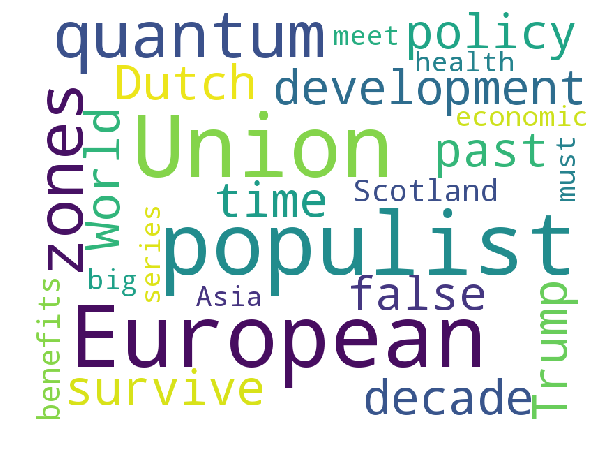

In [10]:
sw = stopwords.words('english')
sw.extend(STOPWORDS)
sw.append("leaving")
sw.append("really")
sw.append("brings")

wordcloud = WordCloud(background_color="white",
                      width = 800,
                      height = 600,
                      max_words=len(df)+10, 
                      stopwords=sw, 
                      random_state=10,
                      max_font_size=125).generate(text)

plt.figure(figsize=(10,12))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()